# Annotation Statistics

## Step 1: Load Libraries

In [1]:
# Install all required packages
!pip install pandas krippendorff statsmodels scikit-learn seaborn matplotlib numpy



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [227]:
import pandas as pd
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.inter_rater import aggregate_raters, fleiss_kappa
import itertools
import seaborn as sns
from scipy.stats import entropy
from sklearn.cluster import KMeans
from scipy.special import rel_entr
from scipy.stats import entropy
import itertools
from collections import Counter




## Step 2: Read and Prepare Data

In [5]:
df = pd.read_csv("./gold_dataset.csv")

#### **Data Cleaning**

<p> We are going to make changes to the dataframe, so that it follows an easy to read and use format.</p>

<p> First, we note that HITId identifies speeches, WorkerId identifies workers, and Input.label is the annotation </p>


In [ ]:
# only keep needed columns and rename 
df_clean = df[['HITId', 'WorkerId', 'Input.parameter', 'Input.label']].copy() #remove unnecessary columns
df_clean.rename(columns={
    'HITId': 'speech_id',
    'WorkerId': 'worker_id',
    'Input.parameter': 'parameter',
    'Input.label': 'label'
}, inplace=True)

# extra cleaning, dropping nulls, making sure all labels are ints, 
df_clean = df_clean.sort_values(by=['parameter', 'speech_id', 'worker_id']).reset_index(drop=True)

# Final preview

df_clean

In [247]:
df['gov_adm_eff'] = df["Answer.manifesto_class.labels"].str.contains("Government and administrative efficiency")

In [248]:
df['gov_adm_eff']

0      False
1      False
2      False
3      False
4       True
       ...  
655    False
656    False
657    False
658    False
659    False
Name: gov_adm_eff, Length: 660, dtype: bool

In [159]:
df_clean

,speech_id,worker_id,parameter,label,worker_label,presence,worker_param
0,31ANT7FQOVKX4DA0R4UV4SEMMZW5HK,A1NBQ61Y6KO3O9,Par303_Governmental and Administrative Efficiency,1,A1NBQ61Y6KO3O9_label_1,1,A1NBQ61Y6KO3O9_Par303_Governmental and Adminis...
1,31ANT7FQOVKX4DA0R4UV4SEMMZW5HK,A3GS2NTQ4XU059,Par303_Governmental and Administrative Efficiency,1,A3GS2NTQ4XU059_label_1,1,A3GS2NTQ4XU059_Par303_Governmental and Adminis...
2,31ANT7FQOVKX4DA0R4UV4SEMMZW5HK,APXGSUB250NVH,Par303_Governmental and Administrative Efficiency,1,APXGSUB250NVH_label_1,1,APXGSUB250NVH_Par303_Governmental and Administ...
3,31MBOZ6PBB9KPU25XZW1AQD3VXRLCF,A1NBQ61Y6KO3O9,Par303_Governmental and Administrative Efficiency,0,A1NBQ61Y6KO3O9_label_0,1,A1NBQ61Y6KO3O9_Par303_Governmental and Adminis...
4,31MBOZ6PBB9KPU25XZW1AQD3VXRLCF,A3GS2NTQ4XU059,Par303_Governmental and Administrative Efficiency,0,A3GS2NTQ4XU059_label_0,1,A3GS2NTQ4XU059_Par303_Governmental and Adminis...
...,...,...,...,...,...,...,...
655,3WRKFXQBPYPV2WV48OHDF1DUHHFIY6,A1X47COW2Y9SEL,Par701702_LabourGroups,2,A1X47COW2Y9SEL_label_2,1,A1X47COW2Y9SEL_Par701702_LabourGroups
656,3WRKFXQBPYPV2WV48OHDF1DUHHFIY6,A335R4YE2E34H6,Par701702_LabourGroups,2,A335R4YE2E34H6_label_2,1,A335R4YE2E34H6_Par701702_LabourGroups
657,3ZURAPD29V5E2ZIBVR4JYHPSURQF10,A1NBQ61Y6KO3O9,Par701702_LabourGroups,2,A1NBQ61Y6KO3O9_label_2,1,A1NBQ61Y6KO3O9_Par701702_LabourGroups
658,3ZURAPD29V5E2ZIBVR4JYHPSURQF10,A1X47COW2Y9SEL,Par701702_LabourGroups,2,A1X47COW2Y9SEL_label_2,1,A1X47COW2Y9SEL_Par701702_LabourGroups


Now, I want to change the dataset to have only 1 row per speech

In [ ]:
# manipulate
df_clean['worker_param'] = df_clean.apply(
    lambda row: f"{row['worker_id']}_{row['parameter']}", axis=1
)

# pivot
df_wide = df_clean.pivot(
    index='speech_id',
    columns='worker_param',
    values='label'
)

df_wide.columns.name = None # no column name idx 

# Optional: reset index if needed
# df_wide = df_wide.reset_index()

# result
pd.set_option('display.max_columns', None)
df_wide



**Secondary Cleaning:**

Create 10 different tables for each parameter

In [235]:
for param in df['Input.parameter'].unique():
    safe_name = "df_" + (
        param.replace('-', '_')
             .replace('&', 'And')
             .replace('.', '')
             .replace(' ', '_')
    )

    df_param = df[df['Input.parameter'] == param].drop_duplicates(subset=['HITId', 'WorkerId'])

    # Pivot without altering index permanently
    pivot = df_param.pivot(
        index='HITId',
        columns='WorkerId',
        values='Input.label'
    ).reset_index()  # <-- Keep HITId as a column

    pivot.columns.name = None

    # Optionally, sort columns so HITId is first
    cols = ['HITId'] + [col for col in pivot.columns if col != 'HITId']
    pivot = pivot[cols]

    globals()[safe_name] = pivot
    print(f"Created variable: {safe_name}")



Created variable: df_Par303_Governmental_and_Administrative_Efficiency
Created variable: df_Par405_Corporatism
Created variable: df_Par402_Incentives
Created variable: df_Par410416_EconomicGrowthAntiGrowth
Created variable: df_Par408_EconomicGoals
Created variable: df_Par409_KeynesianDemandManagement
Created variable: df_Par404_EconomicPlanning
Created variable: df_Par401403_FreeMarket_MarketRegulation
Created variable: df_Par701702_LabourGroups
Created variable: df_Par411_TechnologyAndInfrastructure


In [236]:
df_Par410416_EconomicGrowthAntiGrowth

,HITId,A1BQ37ZGUM16XI,A1NBQ61Y6KO3O9,A1X47COW2Y9SEL,A335R4YE2E34H6,A3GS2NTQ4XU059,APXGSUB250NVH
0,302OLP89EMP3TBB1087B1CXS184CAA,NaN,1.0,1.0,NaN,NaN,1.0
1,3126F2F5GVLPDD1HLIV3HVMQL6HEPL,NaN,2.0,2.0,2.0,NaN,NaN
2,31YWE12TFNU9D7OYK1RE5YGC1VA7XU,0.0,0.0,NaN,NaN,0.0,NaN
3,3421H3BMAXZCW672IUAXSLZ3LNJJ9U,NaN,1.0,NaN,1.0,1.0,NaN
4,34ZTTGSNKK6MXZTYBWIY239DIIVHQV,NaN,2.0,2.0,2.0,NaN,NaN
5,3538U0YQ22CAC2WQIVI2MA4PSOSF36,NaN,1.0,NaN,NaN,1.0,1.0
6,35O6H0UNMFYTVJ5QF4XGG5U1ZR0J53,NaN,2.0,NaN,2.0,NaN,2.0
7,36AZSFEY0RI4BUMTX32CMF5N4X5BV3,NaN,NaN,2.0,2.0,NaN,2.0
8,37J05LC5BK1OZWKJUAFZEHITC8YJDB,NaN,0.0,NaN,NaN,0.0,0.0
9,389A2A305B07SYDJ86AIC6LFSMSC0J,NaN,0.0,0.0,0.0,NaN,NaN


Save Param and workers DF's in a dictionary 

In [ ]:
# define dataframes, workers, etc. 

param_dfs = {
    "Par303_Governmental_and_Administrative_Efficiency": df_Par303_Governmental_and_Administrative_Efficiency,
    "Par405_Corporatism": df_Par405_Corporatism,
    "Par402_Incentives": df_Par402_Incentives,
    "Par410416_EconomicGrowthAntiGrowth": df_Par410416_EconomicGrowthAntiGrowth,
    "Par408_EconomicGoals": df_Par408_EconomicGoals,
    "Par409_KeynesianDemandManagement": df_Par409_KeynesianDemandManagement,
    "Par404_EconomicPlanning": df_Par404_EconomicPlanning,
    "Par401403_FreeMarket_MarketRegulation": df_Par401403_FreeMarket_MarketRegulation,
    "Par701702_LabourGroups": df_Par701702_LabourGroups,
    "Par411_TechnologyAndInfrastructure": df_Par411_TechnologyAndInfrastructure
}

workers = [
    'A1BQ37ZGUM16XI', 
    'A1NBQ61Y6KO3O9', 
    'A1X47COW2Y9SEL', 
    'A335R4YE2E34H6', 
    'A3GS2NTQ4XU059', 
    'APXGSUB250NVH'
]

Save a list of unique speech Id's 

In [ ]:
speeches = df_clean['speech_id'].drop_duplicates()
speeches

0      31ANT7FQOVKX4DA0R4UV4SEMMZW5HK
3      31MBOZ6PBB9KPU25XZW1AQD3VXRLCF
6      35JDMRECDRRJ008IIZ5GNM8YKFUEGH
9      36MUZ9VAFTKGOGYRG948H1517NEED7
12     37VE3DA4ZHZZTTR9SEL87EEEWIUHBJ
                    ...              
645    3SBNLSTU7HNEZBPNCWIL2B6JV6BDZQ
648    3UQ1LLR27XQWWF57DL0A4VNFVU6LAD
651    3UXQ63NLBX41FPAZJZ06Z67LDCRLB8
654    3WRKFXQBPYPV2WV48OHDF1DUHHFIY6
657    3ZURAPD29V5E2ZIBVR4JYHPSURQF10
Name: speech_id, Length: 220, dtype: object

In [245]:
label_range = [0, 1, 2]  # Labels used in your task

param_dfs_label_counts = {}

for param_name, df_param in param_dfs.items():
    count_rows = []

    for _, row in df_param.iterrows():
        label_counts = Counter(row.drop('HITId').astype(int))  # Count 0,1,2 in row
        row_counts = {label: label_counts.get(label, 0) for label in label_range}
        row_counts['HITId'] = row['HITId']
        count_rows.append(row_counts)

    df_counts = pd.DataFrame(count_rows)
    df_counts = df_counts[['HITId'] + label_range]  # Ensure correct column order
    param_dfs_label_counts[param_name] = df_counts

param_dfs_label_counts

{'Par303_Governmental_and_Administrative_Efficiency':                              HITId  0  1  2
 0   31ANT7FQOVKX4DA0R4UV4SEMMZW5HK  2  3  0
 1   31MBOZ6PBB9KPU25XZW1AQD3VXRLCF  5  0  0
 2   35JDMRECDRRJ008IIZ5GNM8YKFUEGH  5  0  0
 3   36MUZ9VAFTKGOGYRG948H1517NEED7  5  0  0
 4   37VE3DA4ZHZZTTR9SEL87EEEWIUHBJ  2  3  0
 5   39N6W9XWS05H65P9I0HAUP0E2RZGYY  5  0  0
 6   3C8QQOM6KCJB2XO5P9SNLTBY82BLIH  2  3  0
 7   3D1TUISJX5IELNBZYNKOCG7HLT4IU8  5  0  0
 8   3E9VAUV7CJWGWEC6W0P0Y3PB4WMAYG  5  0  0
 9   3G9UA71JWIC8INJ93XCDEP8XQXVJ7I  5  0  0
 10  3J9UN9O9KQAU0CJPIYR4ZAYAIJPJ0I  2  3  0
 11  3K3G488TSPQAH693AUHPD66NDMS5QG  2  3  0
 12  3N2YPY1GJTG2IXYD7U42NNB87UIEV6  2  3  0
 13  3P4C70TRNEZX66IAZLSK0HYITPJLGP  5  0  0
 14  3QXFBUZ407Y0PW548ZKLR4U163NUGD  5  0  0
 15  3RKHNXPHHJE5RI1NYQ50PWMUDXTKUL  2  3  0
 16  3SV8KD29MRAMDHVX4D486O19FF8KZA  5  0  0
 17  3UUIU9GZDSNN9M1VRYBKIBHAXTR5TU  2  3  0
 18  3UV0D2KX291VUYFUI9NLWFWV6B0F4D  2  3  0
 19  3X7837UUB0GPEN54KN7L8B81VMBJ6J  2  3  0,
 

## First Try: Krippendorff’s Alpha 

Handles missing data, works for nominal/ordinal; More flexible than Fleiss; can handle ordinal distance metrics too. First we will use Krippendorff's Alpha to compare agreement scores per parameter. 

First, we do this on a parameter basis

In [225]:

for param_name, df_param in param_dfs.items():
    try:
        # cprep data
        ratings = df_param.drop(columns='HITId')
        
        # Compute alpha
        print(f"------------------\nParameter: {param_name}")
        alpha = krippendorff.alpha(reliability_data=ratings, level_of_measurement='nominal')
        print(f"Krippendorff’s Alpha: {alpha:.3f}")
    except Exception as e:
        print(f"Error computing alpha for {param_name}: {e}")

------------------
Parameter: Par303_Governmental_and_Administrative_Efficiency
Krippendorff’s Alpha: 0.042
------------------
Parameter: Par405_Corporatism
Krippendorff’s Alpha: 0.026
------------------
Parameter: Par402_Incentives
Krippendorff’s Alpha: -0.002
------------------
Parameter: Par410416_EconomicGrowthAntiGrowth
Krippendorff’s Alpha: 0.060
------------------
Parameter: Par408_EconomicGoals
Krippendorff’s Alpha: 0.035
------------------
Parameter: Par409_KeynesianDemandManagement
Krippendorff’s Alpha: 0.062
------------------
Parameter: Par404_EconomicPlanning
Krippendorff’s Alpha: 0.012
------------------
Parameter: Par401403_FreeMarket_MarketRegulation
Krippendorff’s Alpha: 0.076
------------------
Parameter: Par701702_LabourGroups
Krippendorff’s Alpha: 0.040
------------------
Parameter: Par411_TechnologyAndInfrastructure
Krippendorff’s Alpha: 0.086


Now, I do this by speech--> each speech will have a multiple parameter scores

In [241]:
for speech in speeches: 
    results = []
    for param_name, df_param in param_dfs.items():

        # list all speeches in this parameter as an array
        speech_array = str(df_param['HITId'].unique())

        if speech in speech_array:
            ratings = df_param.drop(columns='HITId')
            results

**Interpretation: Negative krippendorff scores**<br>

This means annotators disagreed more than expected. <br>

This often means: Labels were applied inconsistently; The task was unclear, or the instructions were ambiguous; There might be confusion between label values (e.g., when to use 0 vs. 2); Or raters may be labeling based on different interpretations of the same text.

## Second Try: Pairwise Cohen Kappa (not working right now)

standard model but can only compare two annotators; therefore, we take a pair-wise approach and loop through annotator pairs

In [ ]:
# annotators = ratings.columns #specify annotators 
# print('-------------------')

# min_overlap = 10

# for a1, a2 in itertools.combinations(annotators, 2):
#     pair = ratings[[a1, a2]].dropna()
#     if len(pair) >= min_overlap:
#         score = cohen_kappa_score(pair[a1], pair[a2])
#         print(f"{a1} vs {a2}: Cohen's Kappa = {score:.3f} (n={len(pair)})")
#     else:
#         print(f"{a1} vs {a2}: not enough overlap (n={len(pair)})")


In [ ]:


# kappa_matrix = pd.DataFrame(index=annotators, columns=annotators, dtype=float)

# for a1, a2 in itertools.combinations(annotators, 2):
#     pair = ratings[[a1, a2]].dropna()
#     if not pair.empty:
#         k = cohen_kappa_score(pair[a1], pair[a2])
#         kappa_matrix.loc[a1, a2] = k
#         kappa_matrix.loc[a2, a1] = k
#     else:
#         kappa_matrix.loc[a1, a2] = None
#         kappa_matrix.loc[a2, a1] = None

# sns.heatmap(kappa_matrix, annot=True, cmap="coolwarm", center=0)
# plt.title("Pairwise Cohen's Kappa")
# plt.show()


Cohen's Kappa will likely not work - even with a pairwise approach. It may be more benificial to do create an aggregate table 

## Third Try: Fleiss' Kappa

In [242]:
param_dfs_label_counts


{'Par303_Governmental_and_Administrative_Efficiency':                              HITId  0  1  2
 0   31ANT7FQOVKX4DA0R4UV4SEMMZW5HK  2  3  0
 1   31MBOZ6PBB9KPU25XZW1AQD3VXRLCF  5  0  0
 2   35JDMRECDRRJ008IIZ5GNM8YKFUEGH  5  0  0
 3   36MUZ9VAFTKGOGYRG948H1517NEED7  5  0  0
 4   37VE3DA4ZHZZTTR9SEL87EEEWIUHBJ  2  3  0
 5   39N6W9XWS05H65P9I0HAUP0E2RZGYY  5  0  0
 6   3C8QQOM6KCJB2XO5P9SNLTBY82BLIH  2  3  0
 7   3D1TUISJX5IELNBZYNKOCG7HLT4IU8  5  0  0
 8   3E9VAUV7CJWGWEC6W0P0Y3PB4WMAYG  5  0  0
 9   3G9UA71JWIC8INJ93XCDEP8XQXVJ7I  5  0  0
 10  3J9UN9O9KQAU0CJPIYR4ZAYAIJPJ0I  2  3  0
 11  3K3G488TSPQAH693AUHPD66NDMS5QG  2  3  0
 12  3N2YPY1GJTG2IXYD7U42NNB87UIEV6  2  3  0
 13  3P4C70TRNEZX66IAZLSK0HYITPJLGP  5  0  0
 14  3QXFBUZ407Y0PW548ZKLR4U163NUGD  5  0  0
 15  3RKHNXPHHJE5RI1NYQ50PWMUDXTKUL  2  3  0
 16  3SV8KD29MRAMDHVX4D486O19FF8KZA  5  0  0
 17  3UUIU9GZDSNN9M1VRYBKIBHAXTR5TU  2  3  0
 18  3UV0D2KX291VUYFUI9NLWFWV6B0F4D  2  3  0
 19  3X7837UUB0GPEN54KN7L8B81VMBJ6J  2  3  0,
 

In [244]:
for param_name, df_counts in param_dfs_label_counts.items():
    try:
        count_matrix = df_counts[[0, 1, 2]].to_numpy()

        # Optional: filter out rows with < 2 total ratings
        count_matrix = count_matrix[count_matrix.sum(axis=1) >= 2]

        kappa = fleiss_kappa(count_matrix)
        print(f"{param_name}: Fleiss' Kappa = {kappa:.3f}")
    except Exception as e:
        print(f"{param_name}: Error computing Fleiss' Kappa: {e}")

Par303_Governmental_and_Administrative_Efficiency: Fleiss' Kappa = 0.286
Par405_Corporatism: Fleiss' Kappa = 0.200
Par402_Incentives: Fleiss' Kappa = 0.286
Par410416_EconomicGrowthAntiGrowth: Fleiss' Kappa = 0.200
Par408_EconomicGoals: Fleiss' Kappa = 0.200
Par409_KeynesianDemandManagement: Fleiss' Kappa = 0.286
Par404_EconomicPlanning: Fleiss' Kappa = 0.286
Par401403_FreeMarket_MarketRegulation: Fleiss' Kappa = 0.200
Par701702_LabourGroups: Fleiss' Kappa = 0.091
Par411_TechnologyAndInfrastructure: Fleiss' Kappa = 0.200


## Visualizing Disagreement

## Annotation Coverage - Other Statistics

**How many samples each annotator labeled**

In [147]:
for param_name, df_param in param_dfs.items():
    try:
        # cprep data
        ratings = df_param.drop(columns='HITId')
        coverage = ratings.notna().sum()
        print(coverage)
    except Exception as e:
        print(f"Error computing coverage for {param_name}: {e}")



WorkerId
A1NBQ61Y6KO3O9    19
A1X47COW2Y9SEL     9
A335R4YE2E34H6    15
A3GS2NTQ4XU059    10
APXGSUB250NVH      7
dtype: int64
WorkerId
A1BQ37ZGUM16XI     2
A1NBQ61Y6KO3O9    17
A1X47COW2Y9SEL    12
A335R4YE2E34H6    12
A3GS2NTQ4XU059     8
APXGSUB250NVH      9
dtype: int64
WorkerId
A1NBQ61Y6KO3O9    15
A1X47COW2Y9SEL    14
A335R4YE2E34H6    16
A3GS2NTQ4XU059     9
APXGSUB250NVH      6
dtype: int64
WorkerId
A1BQ37ZGUM16XI     2
A1NBQ61Y6KO3O9    23
A1X47COW2Y9SEL    18
A335R4YE2E34H6    18
A3GS2NTQ4XU059    15
APXGSUB250NVH     14
dtype: int64
WorkerId
A1BQ37ZGUM16XI     1
A1NBQ61Y6KO3O9    19
A1X47COW2Y9SEL     8
A335R4YE2E34H6     9
A3GS2NTQ4XU059    13
APXGSUB250NVH     10
dtype: int64
WorkerId
A1NBQ61Y6KO3O9    18
A1X47COW2Y9SEL    14
A335R4YE2E34H6    17
A3GS2NTQ4XU059     4
APXGSUB250NVH      7
dtype: int64
WorkerId
A1NBQ61Y6KO3O9    17
A1X47COW2Y9SEL     9
A335R4YE2E34H6    13
A3GS2NTQ4XU059    11
APXGSUB250NVH     10
dtype: int64
WorkerId
A1BQ37ZGUM16XI     1
A1NBQ61Y6KO3O9    

**Missing Annotations**

Which annotators skipped what?

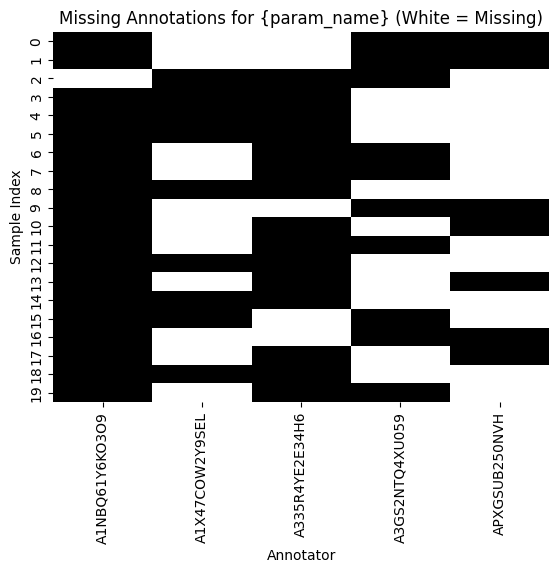

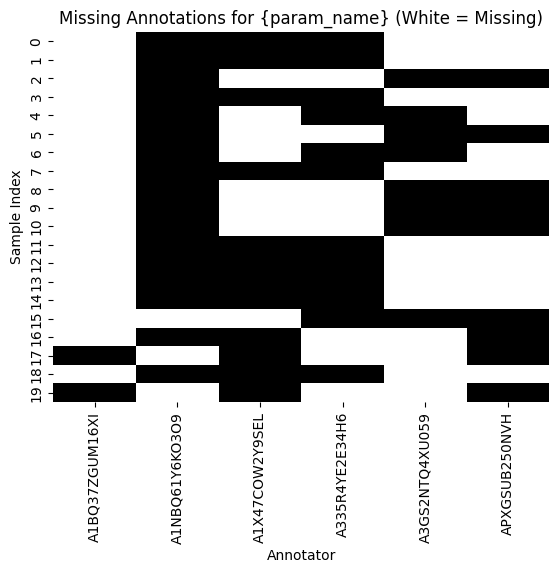

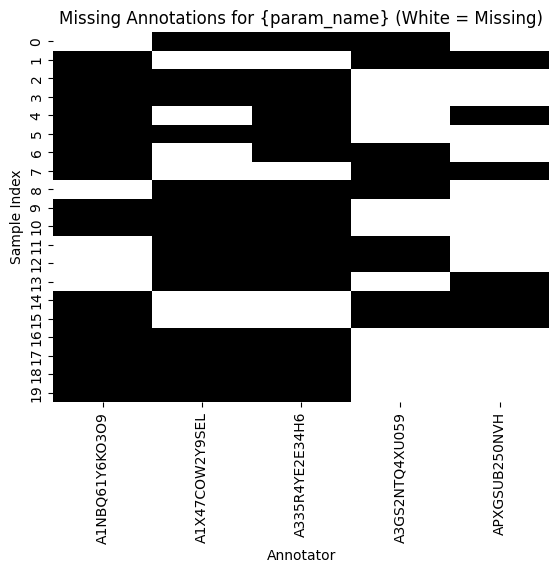

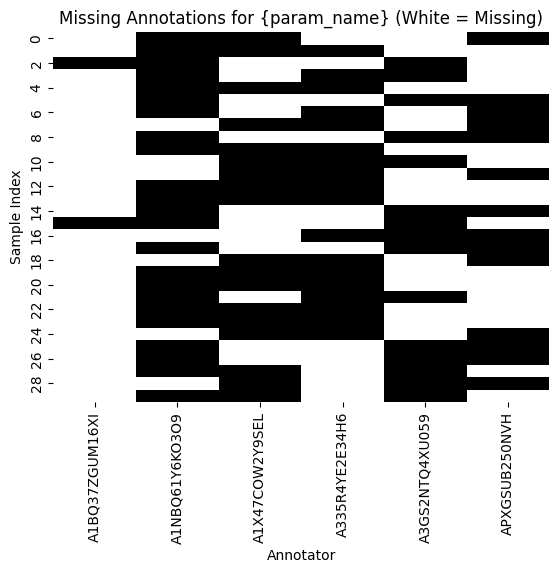

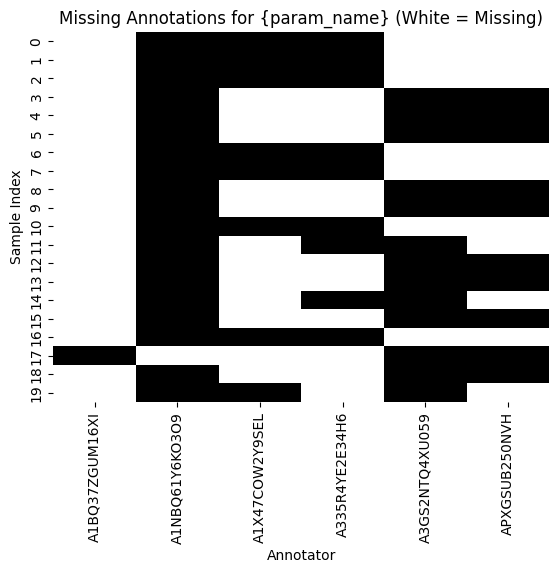

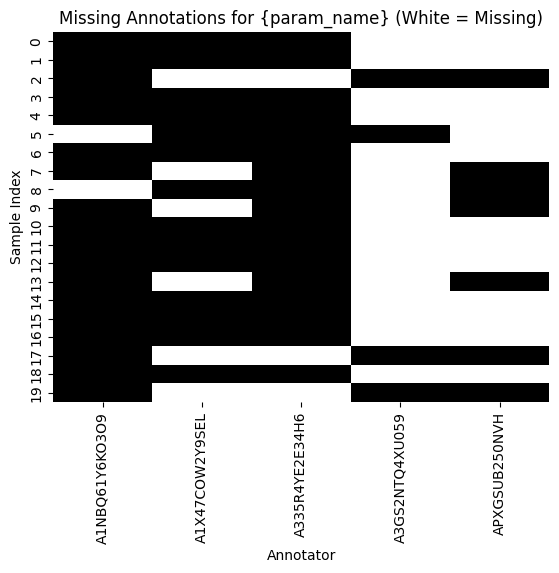

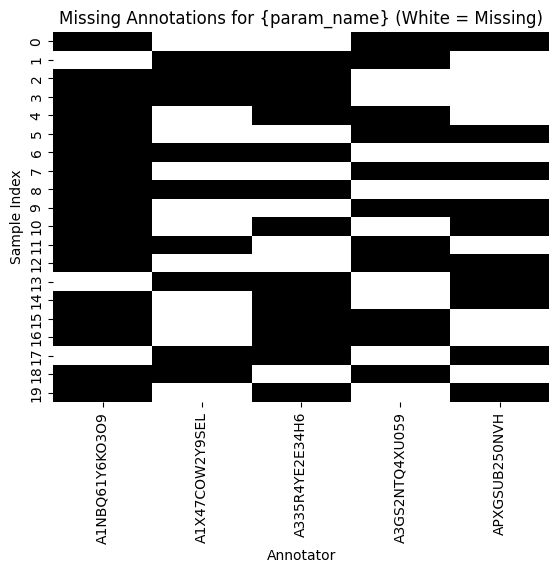

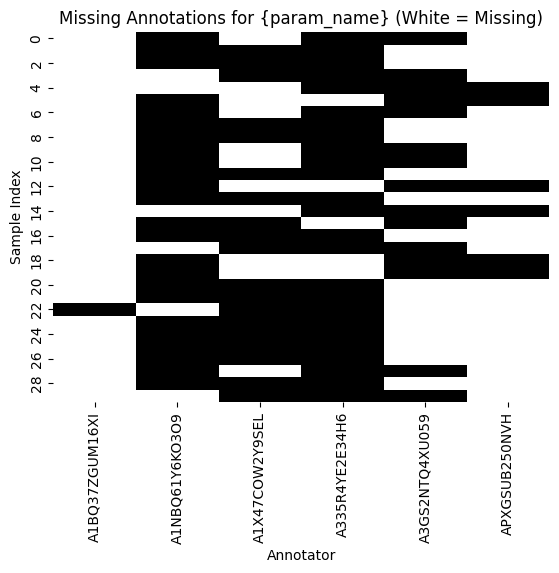

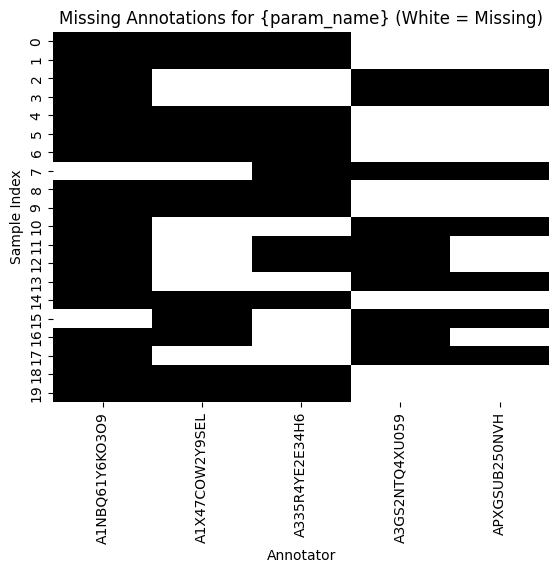

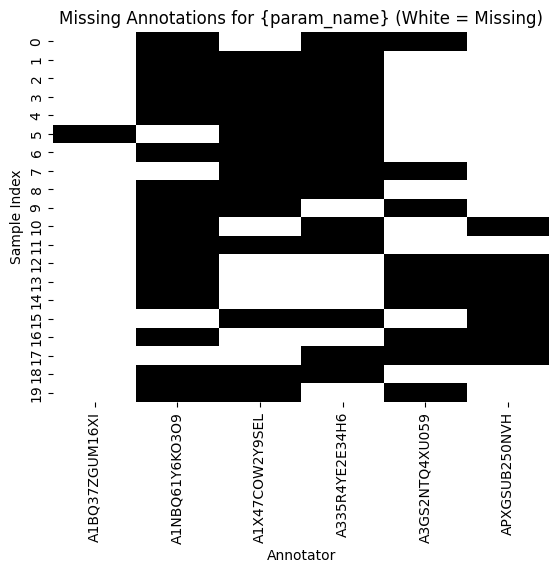

In [ ]:
for param_name, df_param in param_dfs.items():
    try:
        # cprep data
        ratings = df_param.drop(columns='HITId')
        sns.heatmap(ratings.isna(), cbar=False, cmap='gray')
        plt.title("Missing Annotations for -- (White = Missing)")
        plt.xlabel("Annotator")
        plt.ylabel("Sample Index")
        plt.show()
    except Exception as e:
        print(f"Error computing graph for {param_name}: {e}")

**Divergence Overall**

How different are annotators' distributions? *KL divergence (Kullback–Leibler divergence) is a way to measure how different one probability distribution is from another.*

In [ ]:
def kl_divergence(p, q):
    '''kl_div helper to avoid division by 0
    '''
    p = np.array(p) + 1e-10
    q = np.array(q) + 1e-10
    return np.sum(rel_entr(p, q))

label_dists = ratings.apply(lambda col: col.value_counts(normalize=True).reindex([0, 1, 2]).fillna(0))


for a1, a2 in itertools.combinations(label_dists.columns, 2):
    kl = kl_divergence(label_dists[a1], label_dists[a2])
    print(f"{a1} vs {a2}: KL Divergence = {kl:.3f}")


A1BQ37ZGUM16XI vs A1NBQ61Y6KO3O9: KL Divergence = 0.693
A1BQ37ZGUM16XI vs A1X47COW2Y9SEL: KL Divergence = 0.773
A1BQ37ZGUM16XI vs A335R4YE2E34H6: KL Divergence = 0.847
A1BQ37ZGUM16XI vs A3GS2NTQ4XU059: KL Divergence = 0.811
A1BQ37ZGUM16XI vs APXGSUB250NVH: KL Divergence = 0.336
A1NBQ61Y6KO3O9 vs A1X47COW2Y9SEL: KL Divergence = 0.003
A1NBQ61Y6KO3O9 vs A335R4YE2E34H6: KL Divergence = 0.010
A1NBQ61Y6KO3O9 vs A3GS2NTQ4XU059: KL Divergence = 0.006
A1NBQ61Y6KO3O9 vs APXGSUB250NVH: KL Divergence = 0.101
A1X47COW2Y9SEL vs A335R4YE2E34H6: KL Divergence = 0.002
A1X47COW2Y9SEL vs A3GS2NTQ4XU059: KL Divergence = 0.001
A1X47COW2Y9SEL vs APXGSUB250NVH: KL Divergence = 0.140
A335R4YE2E34H6 vs A3GS2NTQ4XU059: KL Divergence = 0.001
A335R4YE2E34H6 vs APXGSUB250NVH: KL Divergence = 0.177
A3GS2NTQ4XU059 vs APXGSUB250NVH: KL Divergence = 0.159


Do annotators agree with the majority ?

In [113]:
majority_vote = ratings.mode(axis=1)[0]

for annotator in ratings.columns:
    match = (ratings[annotator] == majority_vote) & ratings[annotator].notna()
    pct_agree = match.sum() / ratings[annotator].notna().sum()
    print(f"{annotator} agreement with majority: {pct_agree:.2%}")


A1BQ37ZGUM16XI agreement with majority: 100.00%
A1NBQ61Y6KO3O9 agreement with majority: 100.00%
A1X47COW2Y9SEL agreement with majority: 100.00%
A335R4YE2E34H6 agreement with majority: 100.00%
A3GS2NTQ4XU059 agreement with majority: 100.00%
APXGSUB250NVH agreement with majority: 100.00%
